In [ ]:
# This script explores the 1949-2018_DailyPrecipitation.csv,
# 1949-2018_TotalPrecipitation.csv and China_Sta.csv from Shanghai
# Typhoon Center.
# The findings are:
# 1. The daily precipitation measurements can be 1 day early than 
# the start of the typhoon and up to 2 days later than the end 
# of Typhoon track recorded in the best track file.
# 2. Based on the daily precipitation measurements, the typhoon 
# induced rainfall can be as far as 2500km. See dp_distance.describe().
# If only looking at daily preicpitation > 250mm (特大暴雨defined by CMA),
# the furtherest measurement point is abount 1300km from track center.
# 3. The density of measurement data (total precipitation) is 
# shown by station_freq, see the figure. The highest number is arond 470. 
# Most stations with high number of observtions are indeed typhoon impacted area.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import datetime as dt
from shapely.geometry import LineString, Point, Polygon, MultiPoint
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import CRS
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import netCDF4 as nc
import shapely
shapely.speedups.enabled

%matplotlib inline

In [71]:
# IMERG data folder
#IMERG_folder = '/home/lzhou/Precipitation/IMERG/'
#IMERG_folder = r'D:\Precipitation\IMERG'
IMERG_folder = '/media/lzhou/Extreme SSD/Precipitation/IMERG'
CMA_folder = '/home/lzhou/Precipitation/TC_Tracks/CMA_Historical_Data/Wind_Rainfall/'
Output_folder = '/home/lzhou/Precipitation/Output'


In [72]:
os.listdir(CMA_folder)

['1949-2018_Wind.csv',
 '1949-2018_DailyPrecipitation.csv',
 '1951-2018_MaxHourlyPrecipitation.csv',
 '1949-2018_W8Date.csv',
 'read me.txt',
 'China_Sta.csv',
 '.~lock.1949-2018_DailyPrecipitation.csv#',
 '1949-2018_TotalPrecipitation.csv',
 '1949-2018_Gust.csv']

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cn_shape = world[world.name=='China'].copy()
cn_shape.reset_index(drop=True,inplace=True)

In [4]:
# load total precipitation data
df = pd.read_csv(os.path.join(CMA_folder,'1949-2018_TotalPrecipitation.csv'), \
                header=None,names=['SerialID','TCID','StationID','Total_Precip'])
df['SerialID'] = df['SerialID'].astype(int)

best_tracks = gpd.read_file('/home/lzhou/Precipitation/Precipitation_Scripts/Output/CMA_Best_Tracks.shp')
tracks_500km = gpd.read_file('/home/lzhou/Precipitation/Precipitation_Scripts/Output/CMA_Tracks_500km.shp')
tracks_land = gpd.read_file('/home/lzhou/Precipitation/Precipitation_Scripts/Output/CMA_Tracks_on_Land.shp')

precip_ID = df.SerialID.unique()
tracks_500km_ID = tracks_500km[tracks_500km.Year<=2018].CMAID.unique()
tracks_land_ID = tracks_land[tracks_land.Year<=2018].CMAID.unique()
best_tracks_ID = best_tracks[best_tracks.Year<=2018].CMAID.unique()

print(len(precip_ID),len(tracks_land_ID),len(tracks_500km_ID),len(best_tracks_ID))

missing_land_tracks = np.setdiff1d(tracks_land_ID,precip_ID)
missing_500km_tracks = np.setdiff1d(tracks_500km_ID,precip_ID)
precip_tracks_out_of_500km = np.setdiff1d(precip_ID,tracks_500km_ID)
precip_tracks_out_of_land = np.setdiff1d(precip_ID,tracks_land_ID)

print(len(missing_land_tracks),len(missing_500km_tracks),len(precip_tracks_out_of_land),len(precip_tracks_out_of_500km))

955 601 1138 2305
3 227 357 44


In [5]:
# Load best track and nodes information 
best_nodes = gpd.read_file('/home/lzhou/Precipitation/Precipitation_Scripts/Output/CMA_Best_Tracks_Nodes.shp')
best_nodes['Date'] = pd.to_datetime(best_nodes[['Year','Month','Day','Hour']])

In [6]:
# load station data
stations = pd.read_csv(os.path.join(CMA_folder,'China_Sta.csv'))
stations['lat'] = stations['lat'].apply(lambda x: float(x[:2])+int(x[3:5])/60.)
stations['long'] = stations['long'].apply(lambda x: float(x[:3])+int(x[4:6])/60.)
stations.rename(columns={"long": "lon"},inplace=True)
#stations['Lat'] = stations['lat'].apply(lambda x: float(x[:2])+int(x[3:5])/60.)

init_epsg=4326
stations['geometry'] = stations.apply(lambda x: Point((float(x.lon),float(x.lat))),axis=1)
stations = gpd.GeoDataFrame(stations,geometry='geometry')
stations.crs = CRS.from_epsg(init_epsg)

In [7]:
# load daily precipitation data
daily_precip = pd.read_csv(os.path.join(CMA_folder,'1949-2018_DailyPrecipitation.csv'), \
                          header=None,names=['SerialID','TCID','StationID','Date','Precip'])

daily_precip['SerialID'] = daily_precip['SerialID'].astype('int')
daily_precip['StationID'] = daily_precip['StationID'].astype('int')

daily_precip['Date'] = pd.to_datetime(daily_precip['Date'])
daily_precip['Year'] = pd.DatetimeIndex(daily_precip['Date']).year
daily_precip['Month'] = pd.DatetimeIndex(daily_precip['Date']).month
daily_precip['Day'] = pd.DatetimeIndex(daily_precip['Date']).day

In [8]:
# divide daily precipitation data into pre85 and 85-onward two parts, 
# as the daily preicipition accumulate from 0000-2359UTC for pre85 
# period and 1200-1159UTC for 85-onward period
dp84 = daily_precip[daily_precip.Year<=1984].copy()
dp85 = daily_precip[daily_precip.Year>=1985].copy()

In [9]:
# function to calucate distance(km) between station and track center
def Calculate_Station_Track_Distances(dp,stations,best_nodes):
    
    merge_df = pd.merge(dp[['SerialID','StationID','Year','Month','Day']], \
                         best_nodes[['Year','Month','Day','Hour','CMAID','geometry']], \
                         left_on=['SerialID','Year','Month','Day'], \
                         right_on=['CMAID','Year','Month','Day'], how='left')
    
    #merge_df2 = pd.merge(dp[['SerialID','StationID','Year','Month','Day']], \
    #                    best_nodes[['Year','Month','Day','Hour','CMAID','geometry']], \
    #                    left_on=['SerialID','Year','Month','Day'], \
    #                    right_on=['CMAID','Year','Month','Day'], how='left')
    
    merge_df = merge_df.merge(stations[['StationID','geometry']], \
                              left_on='StationID',right_on='StationID',how='left')
    g1 = gpd.GeoSeries(merge_df['geometry_x'])
    g2 = gpd.GeoSeries(merge_df['geometry_y'])
    proj_epsg = 2345 
    g1 = g1.to_crs(epsg=proj_epsg)
    g2 = g2.to_crs(epsg=proj_epsg)
    s1 = g1.distance(g2,align=False)
    s1 = s1/1000.
    
    merge_df['Distance'] = s1
    s2 = merge_df.groupby(['SerialID', 'StationID', 'Year', 'Month', 'Day'])['Distance'].max().to_frame().reset_index()
    dp2 = pd.merge(dp,s2,on=['SerialID', 'StationID', 'Year', 'Month', 'Day'],how='outer')
    
    return dp2

In [10]:
dp84_distance = Calculate_Station_Track_Distances(dp84,stations,best_nodes)

In [11]:
best_nodes_shift12 = best_nodes.copy()
best_nodes_shift12['Date'] = best_nodes['Date']+ pd.DateOffset(hours=12)
best_nodes_shift12['Month'] = pd.DatetimeIndex(best_nodes_shift12['Date']).month
best_nodes_shift12['Day'] = pd.DatetimeIndex(best_nodes_shift12['Date']).day
best_nodes_shift12['Hour'] = pd.DatetimeIndex(best_nodes_shift12['Date']).hour

dp85_distance = Calculate_Station_Track_Distances(dp85,stations,best_nodes_shift12)

In [12]:
dp_distance = dp84_distance.append(dp85_distance)

In [13]:
dp_distance.describe()

,SerialID,TCID,StationID,Precip,Year,Month,Day,Distance
count,30899.000000,30899.000000,30899.000000,30899.000000,30899.000000,30899.000000,30899.000000,29093.000000
mean,198828.508819,5037.584226,58384.007023,22.122292,1988.140846,8.011910,16.180329,696.070097
std,2102.260958,3266.644915,1671.311421,32.568353,21.031125,1.215575,8.877182,336.773419
min,194904.000000,0.000000,50527.000000,0.000000,1949.000000,1.000000,1.000000,30.351650
25%,197019.000000,1409.000000,57993.000000,3.000000,1970.000000,7.000000,8.000000,447.240133
50%,198908.000000,6008.000000,59007.000000,11.000000,1989.000000,8.000000,17.000000,645.182823
75%,200906.000000,7905.000000,59316.000000,27.000000,2009.000000,9.000000,24.000000,886.844435
max,201830.000000,9915.000000,59838.000000,585.000000,2018.000000,12.000000,31.000000,2485.827217


In [35]:
dp_distance[dp_distance.Precip>200].describe()

,SerialID,TCID,StationID,Precip,Year,Month,Day,Distance
count,133.000000,133.000000,133.000000,133.000000,133.00000,133.000000,133.000000,131.000000
mean,198833.278195,5144.338346,59058.323308,264.576692,1988.18797,8.007519,16.248120,417.958688
std,2069.017189,3305.393113,1112.229365,62.981102,20.69444,1.317115,8.561193,259.919488
min,195116.000000,103.000000,54471.000000,201.000000,1951.00000,4.000000,1.000000,94.289683
25%,197114.000000,1508.000000,58666.000000,218.000000,1971.00000,7.000000,9.000000,254.289801
50%,199008.000000,6214.000000,59501.000000,241.000000,1990.00000,8.000000,16.000000,367.096400
75%,200817.000000,7913.000000,59758.000000,305.000000,2008.00000,9.000000,23.000000,490.150853
max,201826.000000,9914.000000,59838.000000,585.000000,2018.00000,11.000000,31.000000,1488.323088


In [39]:
weird=dp_distance[(dp_distance.Distance>1000)&(dp_distance.Precip>=250)]

In [40]:
weird.sort_values(by='Precip',ascending=False).head()

,SerialID,TCID,StationID,Date,Precip,Year,Month,Day,Distance
10715,197712,7707,58362,1977-08-21,375.0,1977,8,21,1227.043704
3147,195914,5904,58040,1959-08-30,277.0,1959,8,30,1170.418969
15936,201723,1720,58666,2017-10-15,268.2,2017,10,15,1281.177430


In [38]:
weird

,SerialID,TCID,StationID,Date,Precip,Year,Month,Day,Distance
3134,195914,5904,54776,1959-08-30,224.0,1959,8,30,1488.323088
3147,195914,5904,58040,1959-08-30,277.0,1959,8,30,1170.418969
4602,196208,6205,58265,1962-07-22,234.0,1962,7,22,1258.360573
6171,196521,6510,54776,1965-07-27,234.0,1965,7,27,1264.569826
10715,197712,7707,58362,1977-08-21,375.0,1977,8,21,1227.043704
15936,201723,1720,58666,2017-10-15,268.2,2017,10,15,1281.177430


In [22]:
df[df.SerialID==201723].sort_values(by='Total_Precip',ascending=False).head()

,SerialID,TCID,StationID,Total_Precip
12365,201723,1720,58666,282.6
12362,201723,1720,58477,272.9
12361,201723,1720,58472,244.3
12380,201723,1720,59501,141.9
12383,201723,1720,59758,123.4


<AxesSubplot:>

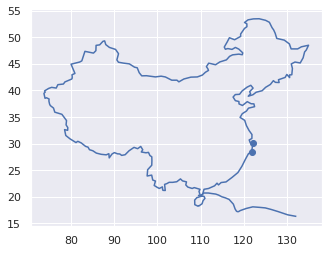

In [32]:
mm=best_tracks[best_tracks.CMAID==201723].plot()
stations[(stations.StationID==58666)|(stations.StationID==58477)].plot(ax=mm)
cn_shape.boundary.plot(ax=mm)

In [33]:
stations[(stations.StationID==58666)|(stations.StationID==58477)]

,ID,StationID,StationName,lat,lon,AltitudeSensor,AltitudeSite,geometry
156,157,58477,DINGHAI,30.033333,122.116667,37.0,999998,POINT (122.11667 30.03333)
159,160,58666,DACHEN DAO,28.450000,121.883333,84.0,999998,POINT (121.88333 28.45000)


<ipython-input-13-0f0220cea324>:5: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  dum1.apply(lambda x: m.annotate(s=x.Year, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);


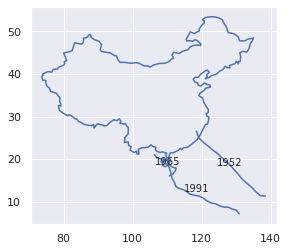

In [13]:
# check the onland tracks that does not have precipitation data from Shanghai Typhoon dataset
dum1 = tracks_land.loc[(tracks_land['CMAID'].isin(missing_land_tracks))].copy()
m=dum1.plot()
cn_shape.boundary.plot(ax=m)
dum1.apply(lambda x: m.annotate(s=x.Year, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

Text(0.5, 1.0, 'Number of data points per station')

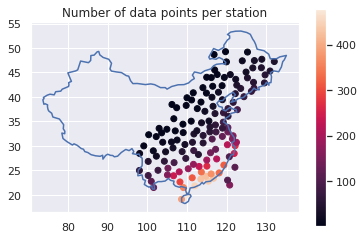

In [70]:
# Number of measurements of total precipitation at each shanghai data stations:
station_freq = df.StationID.value_counts().to_frame().reset_index().rename(columns={'index':'StationID','StationID':'Count'})
station_freq = station_freq.merge(stations,on='StationID')
station_freq = gpd.GeoDataFrame(station_freq,geometry='geometry')
m=station_freq.plot(column='Count',legend=True)
cn_shape.boundary.plot(ax=m)
plt.title('Number of data points per station')